# How to manage state in subgraphs

For more complex systems, sub-graphs are a useful design principle. Sub-graphs allow you to create and manage different states in different parts of your graph. This allows you build things like [multi-agent teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/), where each team can track its own separate state.

In this how-to guide we will cover how to manage the persisted state in subgraphs. This will enable a lot of the human-in-the-loop interaction patterns.

In [3]:
%%capture --no-stderr
%pip install -U langgraph

## Setup SubGraph

First, let's set up our subgraph. For this, we will create a simple graph that can get the weather for a specific city.

In [16]:
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"I'ts sunny in {city}!"

raw_model = ChatOpenAI()
model = raw_model.with_structured_output(get_weather)


class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model.invoke(state['messages'])
    return {"city": result["city"]}

def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state['city']})
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])

## Setup Graph

We can now setup the overall graph. This graph will first route to the subgraph if it needs to get the weather, otherwise it will route to a normal LLM.

In [17]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

router_model = raw_model.with_structured_output(Router)
    
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state['messages']
    route = router_model.invoke(messages)
    return {"route": route['route']}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state['messages'])
    return {"messages": [response]}


def route_after_prediction(state: RouterState):
    if state['route'] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile(checkpointer=memory)

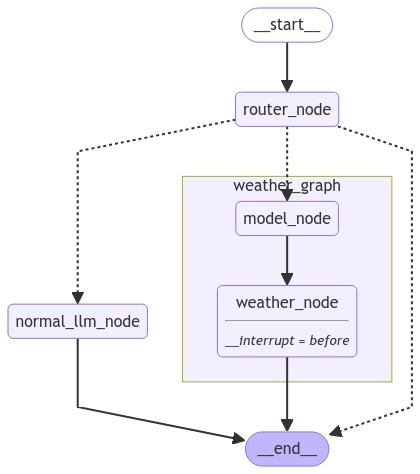

In [18]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's test this out with a normal query!

In [19]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "hi!"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-32af0384-dfde-429d-b81c-e411c0836843-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})]}}


## Resuming from breakpoints

Let's now look at what happens with breakpoints. Let's invoke it with a query that should get routed to the weather subgraph where we have the interrupt node.

In [20]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}


If we get the state now, we can see that it's paused on `weather_graph`

In [21]:
state = graph.get_state(config)
state.next

('weather_graph',)

We can look further inside the `subgraph_state_snapshots` on the state to see the state of any subgraphs. From this, we can see that it is paused at the `weather_node`. Note that we can also see the `city` attribute - this is only available on the state of the subgraph.

In [22]:
state.subgraph_state_snapshots

{'weather_graph': StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", id='25fd45be-8973-4462-8770-fbfb242a1065')], 'city': 'San Francisco'}, next=('weather_node',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph', 'checkpoint_id': '1ef5b8d9-18e7-69e6-8001-96abbb8eff7b'}}, metadata={'source': 'loop', 'writes': {'model_node': {'city': 'San Francisco'}}, 'step': 1}, created_at='2024-08-16T05:08:26.786549+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': 'weather_graph', 'checkpoint_id': '1ef5b8d9-18e7-69e6-8001-96abbb8eff7b'}}, subgraph_state_snapshots=None)}

To resume execution, we can just invoke the outer graph as normal

In [23]:
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)

{'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='25fd45be-8973-4462-8770-fbfb242a1065'), AIMessage(content="I'ts sunny in San Francisco!", id='2f40b062-d065-4367-981d-c3f4238f7072')]}}


## Modifying state

What if we want to modify the state? We can do this by updating the state at the point in time.

By default, when calling `update_state` it

In [24]:
config = {"configurable": {"thread_id": "4"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}


In [25]:
state = graph.get_state(config)
state.values['messages']

[HumanMessage(content="what's the weather in sf", id='032ab116-3cf9-4812-b3d2-12a8f0fa7ec0')]

In [26]:
graph.update_state(config, {"city": "la"})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef5b8d9-4424-601e-8002-d081bfa974d9'}}

In [27]:
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)

{'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", id='032ab116-3cf9-4812-b3d2-12a8f0fa7ec0'), AIMessage(content="I'ts sunny in la!", id='d57a0691-9f80-4ad2-99f0-9e0111df0c07')]}}


If we want to, we we can also update the state by adding a message acting as the weather node in the subgraph. Note that to act as a subgraph we have to specify the `as_node` argument as a list of strings, representing first the subgraph and then the node within that subgraph

In [34]:
config = {"configurable": {"thread_id": "7"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)
graph.update_state(config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node=["weather_graph", "weather_node"])
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)
print(graph.get_state(config).values['messages'])

{'router_node': {'route': 'weather'}}
{'weather_graph': None}
[HumanMessage(content="what's the weather in sf", id='766988e1-6258-43b2-90f0-79756eb6b62e'), AIMessage(content='rainy', id='0851faf4-7a21-42b2-be3c-e3f749da78c7')]


We could also update the graph just acting as the **entire** subgraph. This is done with normal arguments to `as_node`

In [36]:
config = {"configurable": {"thread_id": "8"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)
graph.update_state(config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node=["weather_graph"])
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)
print(graph.get_state(config).values['messages'])

{'router_node': {'route': 'weather'}}
[HumanMessage(content="what's the weather in sf", id='d6260faa-c8ce-4935-af8b-7f0d40e2b211'), AIMessage(content='rainy', id='061291a8-a141-4cc4-8d9a-195c0358d142')]


## Triple nested subgraphs

This same functionality continues to work no matter the level of nesting. Here is an example of doing the same things with a triple nested subgraph. We add another router on top of our already defined graphs.

In [69]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

router_model = raw_model.with_structured_output(Router)
    
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state['messages']
    route = router_model.invoke(messages)
    return {"route": route['route']}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state['messages'])
    return {"messages": [response]}


def route_after_prediction(state: RouterState):
    if state['route'] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile(checkpointer=memory)

In [70]:
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class GrandfatherState(MessagesState):
    to_continue: bool

    
def router_node(state: GrandfatherState):
    # Dummy logic that will always continue
    return {"to_continue": True}



def route_after_prediction(state: GrandfatherState):
    if state['to_continue']:
        return "graph"
    else:
        return END


grandfather_graph = StateGraph(GrandfatherState)
grandfather_graph.add_node(router_node)
grandfather_graph.add_node("graph", graph)
grandfather_graph.add_edge(START, "router_node")
grandfather_graph.add_conditional_edges("router_node", route_after_prediction)
grandfather_graph.add_edge("graph", END)
grandfather_graph = grandfather_graph.compile(checkpointer=MemorySaver())

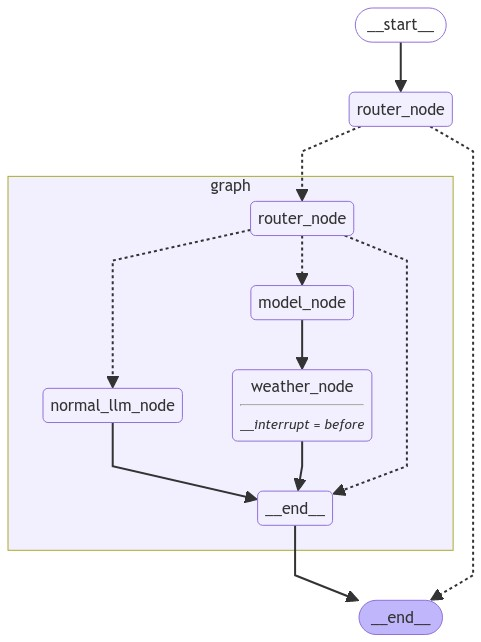

In [71]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(grandfather_graph.get_graph(xray=2).draw_mermaid_png()))

If we run until the interrupt, we can now see that there are snapshots of the state of all three graphs

In [72]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in grandfather_graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'to_continue': True}}


In [73]:
state = grandfather_graph.get_state(config)
print("GrandFather State:")
print(state.values)
print("---------------")
print("Graph State:")
print(state.subgraph_state_snapshots['graph'].values)
print("---------------")
print("SubGraph State:")
print(state.subgraph_state_snapshots['graph'].subgraph_state_snapshots['weather_graph'].values)

GrandFather State:
{'messages': [HumanMessage(content="what's the weather in sf", id='6a8ef68a-3adc-4b09-8655-a85f2ba727b7')], 'to_continue': True}
---------------
Graph State:
{'messages': [HumanMessage(content="what's the weather in sf", id='6a8ef68a-3adc-4b09-8655-a85f2ba727b7')], 'route': 'weather'}
---------------
SubGraph State:
{'messages': [HumanMessage(content="what's the weather in sf", id='6a8ef68a-3adc-4b09-8655-a85f2ba727b7')], 'city': 'San Francisco'}


We can now continue, acting as the node three levels down

In [74]:
grandfather_graph.update_state(config, {"messages": [{"role": "assistant", "content": "rainy"}]}, as_node=["graph", "weather_graph", "weather_node"])
for update in grandfather_graph.stream(None, config=config, stream_mode="updates"):
    print(update)
print(grandfather_graph.get_state(config).values['messages'])

[HumanMessage(content="what's the weather in sf", id='6a8ef68a-3adc-4b09-8655-a85f2ba727b7'), AIMessage(content='rainy', id='b26db454-6d06-42c9-8a56-ba30573b64d5')]
